# Embedding model

In [6]:
import tensorflow as tf
import numpy as np
from dataset import Dataset
from layers import *
from model import Model
from dbase import DataBase
from visualisation import show_similarity

## Dataset

In [7]:
tr_data_path = "/netforge/datasets/private/roman/coins/2017-11-29/datasets/train/500_300_128_128_1_uint8.npy"
va_data_path = "/netforge/datasets/private/roman/coins/2017-11-29/datasets/valid/550_300_128_128_1_uint8.npy"
tr_dataset   = Dataset(tr_data_path)
va_dataset   = Dataset(va_data_path)
tr_dataset.load()
va_dataset.load()
image_shape  = list(tr_dataset.data.shape[-3:])
print("Train:", tr_dataset.data.shape, tr_dataset.data.dtype)
print("Valid:", va_dataset.data.shape, va_dataset.data.dtype)

Train dataset: (500, 300, 128, 128, 1) uint8
Valid dataset: (550, 300, 128, 128, 1) uint8


## Networks

In [8]:
def simple_conv(images, out_dim, reuse, training):
    use_bn = False
    l = images
    l = conv2d(l,  16, reuse, training, use_bn, pool=True, name='conv_1')
    l = conv2d(l,  32, reuse, training, use_bn, pool=True, name='conv_2')
    l = conv2d(l,  64, reuse, training, use_bn, pool=True, name='conv_3')
    l = conv2d(l, 128, reuse, training, use_bn, pool=True, name='conv_4')
    l = conv2d(l, 256, reuse, training, use_bn, pool=True, name='conv_5')
    l = flatten(l)
    l = dense(l, 4096, reuse, name='fc_1')
    l = dense(l, 4096, reuse, name='fc_2')
    l = dense(l, out_dim, reuse, name='out')
    l = normalize(l)
    return l


def VGG16(images, out_dim, reuse, training):
    use_bn = False
    l = images     # -> 128
    
    l = conv2d(l,  32, reuse, training, use_bn, name='conv_1_1')
    l = conv2d(l,  32, reuse, training, use_bn, name='conv_1_2')
    l = maxpool(l) # -> 64

    l = conv2d(l,  64, reuse, training, use_bn, name='conv_2_1')
    l = conv2d(l,  64, reuse, training, use_bn, name='conv_2_2')
    l = maxpool(l) # -> 32

    l = conv2d(l, 128, reuse, training, use_bn, name='conv_3_1')
    l = conv2d(l, 128, reuse, training, use_bn, name='conv_3_2')
    l = conv2d(l, 128, reuse, training, use_bn, name='conv_3_3')
    l = maxpool(l) # -> 16
    
    l = conv2d(l, 256, reuse, training, use_bn, name='conv_4_1')
    l = conv2d(l, 256, reuse, training, use_bn, name='conv_4_2')
    l = conv2d(l, 256, reuse, training, use_bn, name='conv_4_3')
    l = maxpool(l) # -> 8
    
    l = conv2d(l, 256, reuse, training, use_bn, name='conv_5_1')
    l = conv2d(l, 256, reuse, training, use_bn, name='conv_5_2')
    l = conv2d(l, 256, reuse, training, use_bn, name='conv_5_3')
    l = maxpool(l) # -> 4 x 4 x 256 = 4096
    
    l = flatten(l)
    
    l = dense(l, 4096, reuse, name='fc_1')
    l = dense(l, 4096, reuse, name='fc_2')
    l = dense(l, out_dim, reuse, name='out')
    
    l = normalize(l)
    
    return l


def AlexNet(images, out_dim, reuse, training):
    use_bn = False
    l = images     # -> 128
    
    l = conv2d(l,  48, reuse, training, use_bn, name='conv_1_1')
    l = maxpool(l) # -> 64

    l = conv2d(l, 128, reuse, training, use_bn, name='conv_2_1')
    l = maxpool(l) # -> 32

    l = conv2d(l, 192, reuse, training, use_bn, name='conv_3_1')
    l = conv2d(l, 192, reuse, training, use_bn, name='conv_3_2')
    l = maxpool(l) # -> 16
    
    l = conv2d(l, 128, reuse, training, use_bn, name='conv_3_3')
    l = maxpool(l) # -> 8 x 8 x 128 = 8192
    
    l = flatten(l)
    
    l = dense(l, 2048, reuse, name='fc_1')
    l = dense(l, 2048, reuse, name='fc_2')
    l = dense(l, out_dim, reuse, name='out')
    
    l = normalize(l)
    
    return l

## Model 

In [17]:
out_dims      = 256
margin        = .2
nn_arc        = VGG16
learning_rate = 1e-5
batch_size    = 64

In [10]:
%%time
model = Model(image_shape, out_dims)
model.build(nn_arc)

CPU times: user 15 s, sys: 492 ms, total: 15.5 s
Wall time: 15.5 s


## Train

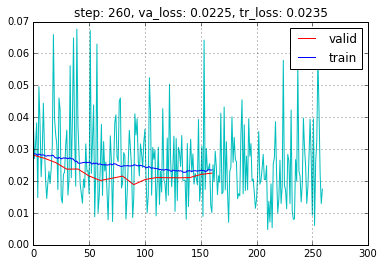

In [ ]:
%%time
model.train(
    step_num   = 10000, 
    tr_dataset = tr_dataset,
    va_dataset = va_dataset,
    margin     = margin,
    batch_size = batch_size, 
    lr         = learning_rate)
model.save("models/hash_model/003/")

## Database

In [14]:
%%time
dbase = DataBase()
ethalons  = va_dataset.get_ethalons()
augmented = va_dataset.get_augmented()
dbase.build(model, ethalons)
print("Ethalons :", list(ethalons.shape))
print("Augmented:", list(augmented.shape))
print('-'*50)

Ethalons : [550, 128, 128, 1]
Augmented: [550, 128, 128, 1]
--------------------------------------------------
CPU times: user 1.09 s, sys: 160 ms, total: 1.25 s
Wall time: 1.48 s


## Accuracy

In [15]:
%%time
def accuracy(ind, k):
    assert 0 < k <= ind.shape[1]
    err = 0
    N   = len(ind)
    for i in range(N):
        ok = False
        for j in range(k):
            if i==ind[i,j]:
                ok = True
        err+= not ok
    return ((N-err)/N*100)

ind, dist = dbase.query(augmented, 3)
print("Database: %s" % list(dbase.images.shape))
print("Request : %s" % list(augmented.shape))
print('-'*50)
for k in range(1, ind.shape[1]+1):
    print("Accuracy@%d: %.1f%%" % (k, accuracy(ind, k)))
print('-'*50)

Database: [550, 128, 128, 1]
Request : [550, 128, 128, 1]
--------------------------------------------------
Accuracy@1: 38.4%
Accuracy@2: 46.4%
Accuracy@3: 51.6%
--------------------------------------------------
CPU times: user 164 ms, sys: 8 ms, total: 172 ms
Wall time: 489 ms


## Searching

Average distance: 0.20


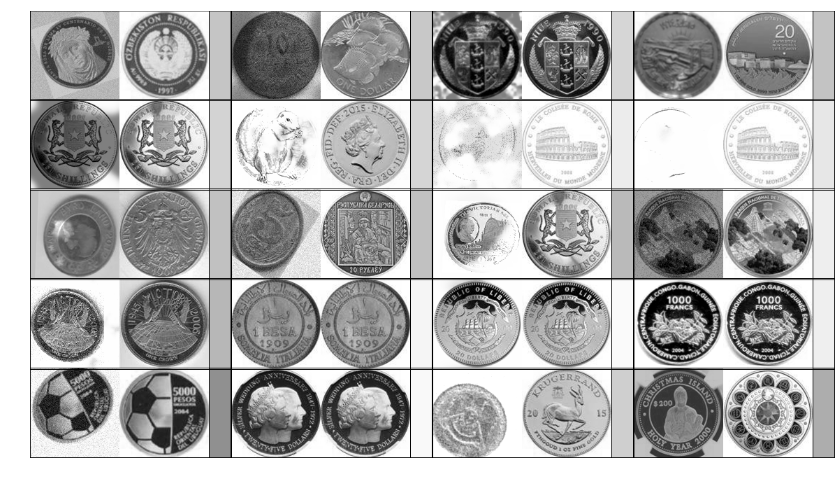

In [16]:
def search(request, max_k=0):
    ind, dist  = dbase.query(request, 3)
    per = np.random.choice(range(len(ind)), len(ind), replace=False)
    im1 = request[per]
    for k in range(0, max_k+1):
        print("Average distance: %.2f" % np.mean(dist[:,k]))
        im2 = dbase.images[ind[:,k]][per]
        sim = 1-dist[:,k][per]
        num = 20
        im1 = im1[:num]
        im2 = im2[:num]
        sim = sim[:num]
        show_similarity(im1, im2, sim, cols=4)

search(augmented)

## Restore model

In [6]:
model.restore("models/hash_model/003/")

INFO:tensorflow:Restoring parameters from models/hash_model/003/
